# AQS Modelling: Part 3

## Setup

In [140]:
# data wrangling
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.model_selection import train_test_split

# models
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import statsmodels.formula.api as smf
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# evaluation
from sklearn.metrics import mean_squared_error

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
%matplotlib inline

sns.set_context('notebook')
sns.set_style('white')

In [ ]:
aqs_misr = pd.read_csv('../data/merged/WithCL_MISR_AQS_2000_2021.csv')

## Data Wrangling

### Remove NAs in AOD

In [142]:
df = aqs_misr.dropna(subset = ['AOD'])

In [143]:
percent_dropped = round((1 - (df.shape[0]/aqs_misr.shape[0]))*100, 2)
print("Original data dimension:",aqs_misr.shape[0], "observations,", aqs_misr.shape[1], "features.")
print("New data dimension:",df.shape[0], "observations,", df.shape[1], "features.")
print(f"Percent dropped: {percent_dropped}")

Original data dimension: 157005 observations, 267 features.
New data dimension: 50089 observations, 267 features.
Percent dropped: 68.1


### Feature Engineering

In [ ]:
# Create year, month variables
df['Year'] = pd.DatetimeIndex(df.loc[:, 'Date']).year.astype('category')
df['Month'] = pd.DatetimeIndex(df.loc[:, 'Date']).month.astype('category')

# Cast other categorical variables to the right type

for col in ['POC', 'Site.Code', 'light', 'med', 'heavy']:
    df[col] = df.loc[:, col].astype('category')

# Replace NAs in smoke vars with 0
df['light'].fillna(0, inplace=True)
df['med'].fillna(0, inplace=True)
df['heavy'].fillna(0, inplace=True)

# Replace NAs in cluster info vars with 0
df['frp_avg'].fillna(-999, inplace=True)
df['frp_vars'].fillna(-999, inplace=True)
df['num_pts'].fillna(0, inplace=True)

# First type: create quantiles for fire distance; placeholder "x+1"th quantile for NAs
df['fire_dist_25'] = pd.qcut(df['fire_dist'], q=[0, .25, .5, .75, 1.], labels=[1,2,3,4])
df['fire_dist_25'] = df['fire_dist_25'].cat.add_categories(5)
df['fire_dist_25'].fillna(5, inplace=True)

## Models with different AOD subsets

### Helper Functions

In [145]:
def plot_fitted(true_value, predicted_value, title, save_path):
    plt.figure(figsize=(5,5))
    plt.scatter(true_value, predicted_value, s=5, c="crimson")
    plt.yscale('log')
    plt.xscale('log')

    p1 = max(max(predicted_value), max(true_value))
    p2 = min(min(predicted_value), min(true_value))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Values', fontsize=11)
    plt.ylabel('Predictions', fontsize=11)
    plt.axis('equal')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

def print_perf(mod, preds, X_test, y_test, method):
    rmse = round(np.sqrt(mean_squared_error(y_test, preds)), 2)
    r2 = round(mod.score(X_test, y_test), 2)
    print("="*10)
    print(f"Model Performance: {method}")
    print("RMSE: ", rmse)
    print("R2: ", r2)

def plot_imp(mod, feature_list, title, save_path):
    # Specify feature names
    mod.get_booster().feature_names = feature_list
    # Plot in a graph with top 10 features
    ax = xgb.plot_importance(mod.get_booster(), max_num_features=10)
    plt.tight_layout()
    plt.title(title)
    ax.figure.savefig(save_path)

In [146]:
labels = np.array(df['PM25'])
subset_features = ['Year', 'Month', 'POC', 'Site.Latitude', 'Site.Longitude', 'elevation', 'fire_dist_25', 'light', 'med', 'heavy','frp_avg', 'frp_vars', 'num_pts', 'ecosys']

### AOD only

In [147]:
aod_features = subset_features + ['AOD']
aod_only = pd.get_dummies(df[aod_features], columns = ['POC', 'fire_dist_25'])
feature_list_aod_only = list(aod_only.columns)
features_aod_only = np.array(aod_only)

In [148]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(features_aod_only, labels, test_size = 0.3, random_state = 88)
print('Training Features Shape:', X_train1.shape)
print('Training Labels Shape:', y_train1.shape)
print('Testing Features Shape:', X_test1.shape)
print('Testing Labels Shape:', y_test1.shape)

Training Features Shape: (35062, 28)
Training Labels Shape: (35062,)
Testing Features Shape: (15027, 28)
Testing Labels Shape: (15027,)


In [149]:
xgb_mod1 = xgb.XGBRegressor(objective="reg:squarederror", subsample=1.0, min_child_weight=1, max_depth=10, gamma=1.5, colsample_bytree=1.0, random_state=88)
xgb_mod1.fit(X_train1, y_train1)
preds_xgb1 = xgb_mod1.predict(X_test1)

### Raw AOD & etc.

In [150]:
aod_add_features = subset_features + ['AOD', 'AOD_absorption', 'AOD_nonspherical', 'small_mode_AOD', 'medium_mode_AOD', 'large_mode_AOD']
aod_info = pd.get_dummies(df[aod_add_features], columns = ['POC', 'fire_dist_25'])
feature_list_aod_info = list(aod_info.columns)
features_aod_info = np.array(aod_info)

In [151]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(features_aod_info, labels, test_size = 0.3, random_state = 88)
print('Training Features Shape:', X_train2.shape)
print('Training Labels Shape:', y_train2.shape)
print('Testing Features Shape:', X_test2.shape)
print('Testing Labels Shape:', y_test2.shape)

Training Features Shape: (35062, 33)
Training Labels Shape: (35062,)
Testing Features Shape: (15027, 33)
Testing Labels Shape: (15027,)


In [152]:
xgb_mod2 = xgb.XGBRegressor(objective="reg:squarederror", subsample=1.0, min_child_weight=1, max_depth=10, gamma=1.5, colsample_bytree=1.0, random_state=88)
xgb_mod2.fit(X_train2, y_train2)
preds_xgb2 = xgb_mod2.predict(X_test2)

### AOD mix

In [159]:
aod_mix_features = subset_features + ['aod_mix_01', 'aod_mix_02', 'aod_mix_03', 'aod_mix_04', 'aod_mix_05', 'aod_mix_06', 'aod_mix_07', 'aod_mix_08', 'aod_mix_09', 'aod_mix_10', 'aod_mix_11', 'aod_mix_12', 'aod_mix_13', 'aod_mix_14', 'aod_mix_15', 'aod_mix_16', 'aod_mix_17', 'aod_mix_18', 'aod_mix_19', 'aod_mix_20', 'aod_mix_21', 'aod_mix_22', 'aod_mix_23', 'aod_mix_24', 'aod_mix_25', 'aod_mix_26', 'aod_mix_27', 'aod_mix_28', 'aod_mix_29', 'aod_mix_30', 'aod_mix_31', 'aod_mix_32', 'aod_mix_33', 'aod_mix_34', 'aod_mix_35', 'aod_mix_36', 'aod_mix_37', 'aod_mix_38', 'aod_mix_39', 'aod_mix_40', 'aod_mix_41', 'aod_mix_42', 'aod_mix_43', 'aod_mix_44', 'aod_mix_45', 'aod_mix_46', 'aod_mix_47', 'aod_mix_48', 'aod_mix_49', 'aod_mix_50', 'aod_mix_51', 'aod_mix_52', 'aod_mix_53', 'aod_mix_54', 'aod_mix_55', 'aod_mix_56', 'aod_mix_57', 'aod_mix_58', 'aod_mix_59', 'aod_mix_60', 'aod_mix_61', 'aod_mix_62', 'aod_mix_63', 'aod_mix_64', 'aod_mix_65', 'aod_mix_66', 'aod_mix_67', 'aod_mix_68', 'aod_mix_69', 'aod_mix_70', 'aod_mix_71', 'aod_mix_72', 'aod_mix_73', 'aod_mix_74']
aod_mix = pd.get_dummies(df[aod_mix_features], columns = ['POC', 'fire_dist_25'])
feature_list_aod_mix = list(aod_mix.columns)
features_aod_mix = np.array(aod_mix)

In [160]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(features_aod_mix, labels, test_size = 0.3, random_state = 88)
print('Training Features Shape:', X_train3.shape)
print('Training Labels Shape:', y_train3.shape)
print('Testing Features Shape:', X_test3.shape)
print('Testing Labels Shape:', y_test3.shape)

Training Features Shape: (35062, 101)
Training Labels Shape: (35062,)
Testing Features Shape: (15027, 101)
Testing Labels Shape: (15027,)


In [161]:
xgb_mod3 = xgb.XGBRegressor(objective="reg:squarederror", subsample=1.0, min_child_weight=1, max_depth=10, gamma=1.5, colsample_bytree=1.0, random_state=88)
xgb_mod3.fit(X_train3, y_train3)
preds_xgb3 = xgb_mod3.predict(X_test3)

### Results

In [162]:
print_perf(xgb_mod1, preds_xgb1, X_test1, y_test1, "AOD only")
print_perf(xgb_mod2, preds_xgb2, X_test2, y_test2, "Raw AOD+")
print_perf(xgb_mod3, preds_xgb3, X_test3, y_test3, "AOD mix")

Model Performance: AOD only
RMSE:  3.91
R2:  0.8
Model Performance: Raw AOD+
RMSE:  4.08
R2:  0.79
Model Performance: AOD mix
RMSE:  3.91
R2:  0.8


The three models don't have a significant difference in RMSE and R2 scores.

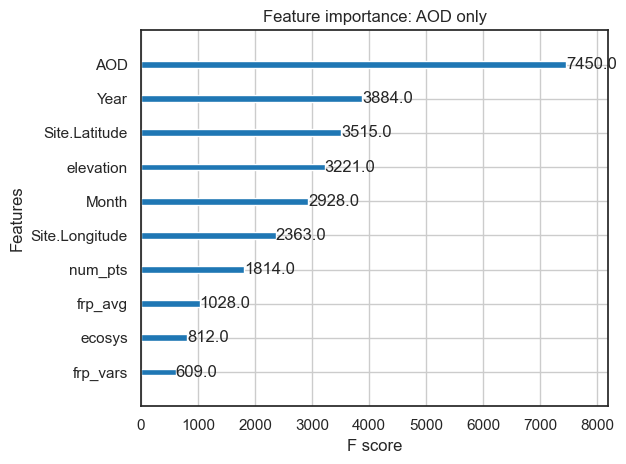

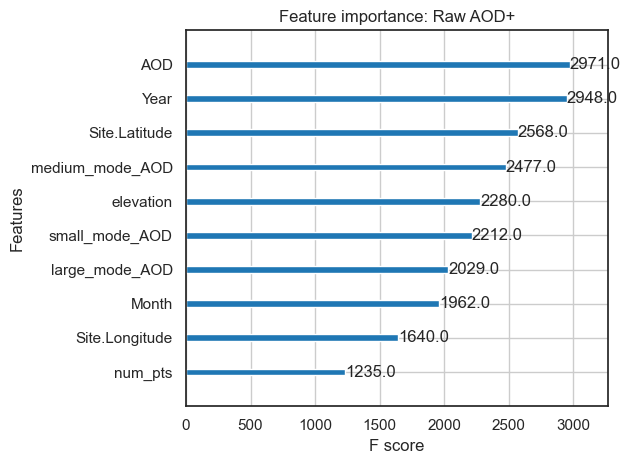

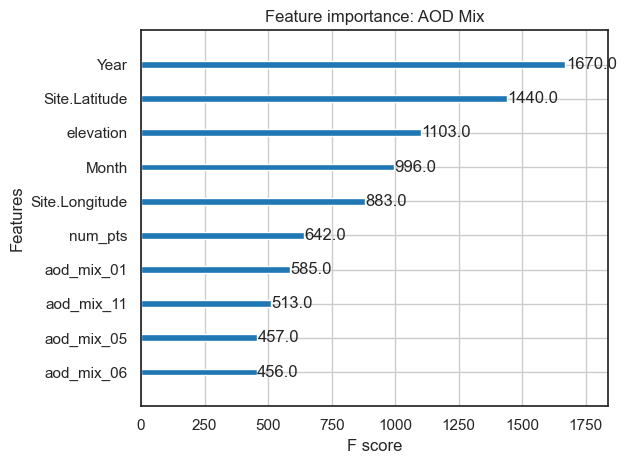

In [157]:
plot_imp(xgb_mod1, feature_list_aod_only, "Feature importance: AOD only", "../img/ft_imp-aod_only.png")
plot_imp(xgb_mod2, feature_list_aod_info, "Feature importance: Raw AOD+", "../img/ft_imp-raw_aod.png")
plot_imp(xgb_mod3, feature_list_aod_mix, "Feature importance: AOD Mix", "../img/ft_imp-aod_mix.png")


- Both `AOD-only` and `Raw-AOD+` models list AOD as the highest contributing feature
- `ecosys` appeared as an important feature in `AOD-only` but not the others
- Ranking for features is the same for non-AOD features in all three models

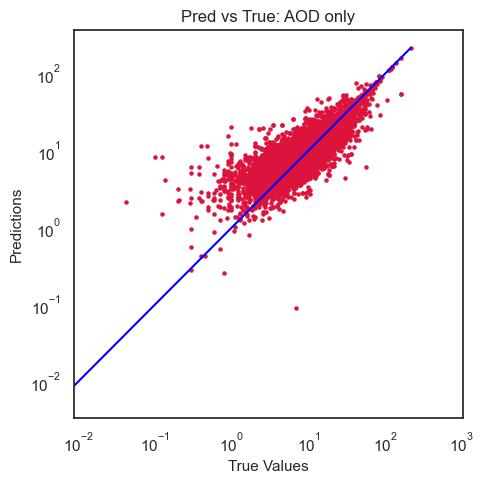

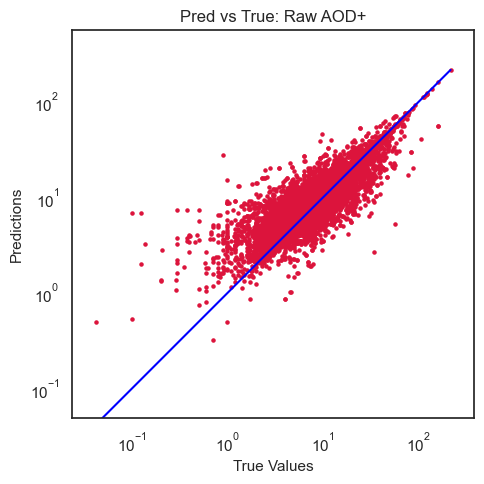

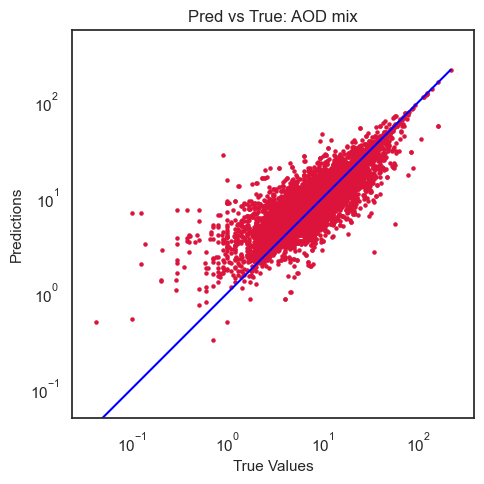

In [158]:
plot_fitted(y_test1, preds_xgb1, "Pred vs True: AOD only", "../img/pred_true-aod_only.png")
plot_fitted(y_test3, preds_xgb3, "Pred vs True: Raw AOD+", "../img/pred_true-raw_aod.png")
plot_fitted(y_test3, preds_xgb3, "Pred vs True: AOD mix", "../img/pred_true-aod_mix.png")

- Most concentrated for `AOD-only`
- Models tend to overestimate PM2.5; more or less constant variance for error